In [7]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from utils import show_prompt
from Autonomous_Learning_Agent.prompts import clarify_with_user_instructions
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

In [9]:
%%writefile ../src/Autonomous_Learning_Agent/state_scope.py

"""State Definitions and Pydantic Schemas for Research Scoping.

This defines the state objects and structured schemas used for
the research agent scoping workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# ===== STATE DEFINITIONS =====

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.
    
    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """

    # Research brief generated from user conversation history
    research_brief: Optional[str]
    # Messages exchanged with the supervisor agent for coordination
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Raw unprocessed research notes collected during the research phase
    raw_notes: Annotated[list[str], operator.add] = []
    # Processed and structured notes ready for report generation
    notes: Annotated[list[str], operator.add] = []
    # Final formatted research report
    final_report: str

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""
    
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

Overwriting ../src/Autonomous_Learning_Agent/state_scope.py


In [10]:
%%writefile ../src/Autonomous_Learning_Agent/research_agent_scope.py

"""User Clarification and Research Brief Generation.

This module implements the scoping phase of the research workflow, where we:
1. Assess if the user's request needs clarification
2. Generate a detailed research brief from the conversation

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with research.
"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from Autonomous_Learning_Agent.prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
from Autonomous_Learning_Agent.state_scope import AgentState, ClarifyWithUser, ResearchQuestion, AgentInputState

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    from datetime import datetime
    now = datetime.now()
    return f"{now.strftime('%a %b')} {now.day}, {now.year}"


# ===== CONFIGURATION =====

# Initialize model
model = init_chat_model("google_genai:models/gemini-flash-lite-latest")

# ===== WORKFLOW NODES =====

def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Determine if the user's request contains sufficient information to proceed with research.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState):
    """
    Transform the conversation history into a comprehensive research brief.
    
    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

# ===== GRAPH CONSTRUCTION =====

# Build the scoping workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

# Compile the workflow
scope_research = deep_researcher_builder.compile()

Overwriting ../src/Autonomous_Learning_Agent/research_agent_scope.py


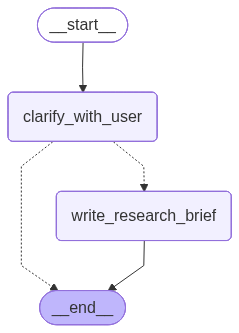

In [11]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from Autonomous_Learning_Agent.research_agent_scope import deep_researcher_builder

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [12]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To provide you with the best research on coffee shops in San Francisco, could you specify what criteria you are │
│ most interested in? For example, are you looking for the best based on:                                         │
│ 1. Ambiance/Seating (e.g., good for working remotely)?                                                          │
│ 2. Coffee quality/Roaster reputation?                                                                           │
│ 3. Specific neighborhoods?                                                                                      │
│ 4. Price range?                                                                                                 │
│ 5. Unique offerings (e.g., pastries, specific brewing methods)?                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco Coffee quality/Roaster reputation")]}, config=thread)
format_messages(result['messages'])

ChatGoogleGenerativeAIError: Error calling model 'models/gemini-flash-lite-latest' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 3.273082054s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '3s'}]}}